# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Update | Creating models |
| 05/10/2025 | Adrienne | Update | Created baseline model with KMeans

# Content

* [Introduction](#introduction)

In [53]:

import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt

## Load Data

In [25]:
path = "../data/clean"

df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

In [63]:
df_lab_enc.head()

,patient_medicare_number,gender,age,number_of_claims,total_value,category_0_enc,category_1_enc,category_2_enc,category_3_enc,category_4_enc,...,hcpcs_315_enc,hcpcs_316_enc,hcpcs_317_enc,hcpcs_318_enc,hcpcs_319_enc,hcpcs_320_enc,hcpcs_321_enc,hcpcs_322_enc,hcpcs_323_enc,hcpcs_324_enc
0,0,0,76.0,51,250.43,2,1,1,1,1,...,38,38,38,38,38,38,38,38,38,38
1,1,0,77.0,21,6665.78,2,1,1,2,2,...,38,38,38,38,38,38,38,38,38,38
2,2,0,75.0,17,230.82,1,1,2,2,2,...,38,38,38,38,38,38,38,38,38,38
3,3,0,76.0,23,234.72,1,1,2,2,1,...,38,38,38,38,38,38,38,38,38,38
4,4,0,75.0,22,234.72,1,2,1,2,1,...,38,38,38,38,38,38,38,38,38,38


We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared

### Baseline Model

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lab_enc)

Dimensionality Reduction

In [66]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

In [67]:
len(explained_variance_ratio )

5

In [68]:
components = pca.components_
feature_names = df_lab_enc.columns
feature_contributions = pd.DataFrame(components, columns=feature_names)

print(feature_contributions)


   patient_medicare_number    gender       age  number_of_claims  total_value  \
0                -0.006720  0.001622 -0.008813         -0.015968     0.003538   
1                -0.003239 -0.004268 -0.008717         -0.035876     0.005127   
2                 0.013794 -0.005211  0.005769          0.035764    -0.001155   
3                 0.019580 -0.021028 -0.026290         -0.043020     0.015969   
4                 0.016231 -0.004727 -0.009212          0.003614    -0.009142   

   category_0_enc  category_1_enc  category_2_enc  category_3_enc  \
0       -0.005512        0.000751       -0.006310       -0.008676   
1        0.002760        0.003853        0.007089        0.003384   
2       -0.036057        0.004646       -0.009623       -0.017043   
3        0.013280        0.018248        0.014795        0.043121   
4        0.014033        0.028310       -0.021571       -0.015912   

   category_4_enc  ...  hcpcs_315_enc  hcpcs_316_enc  hcpcs_317_enc  \
0       -0.006553  ...     

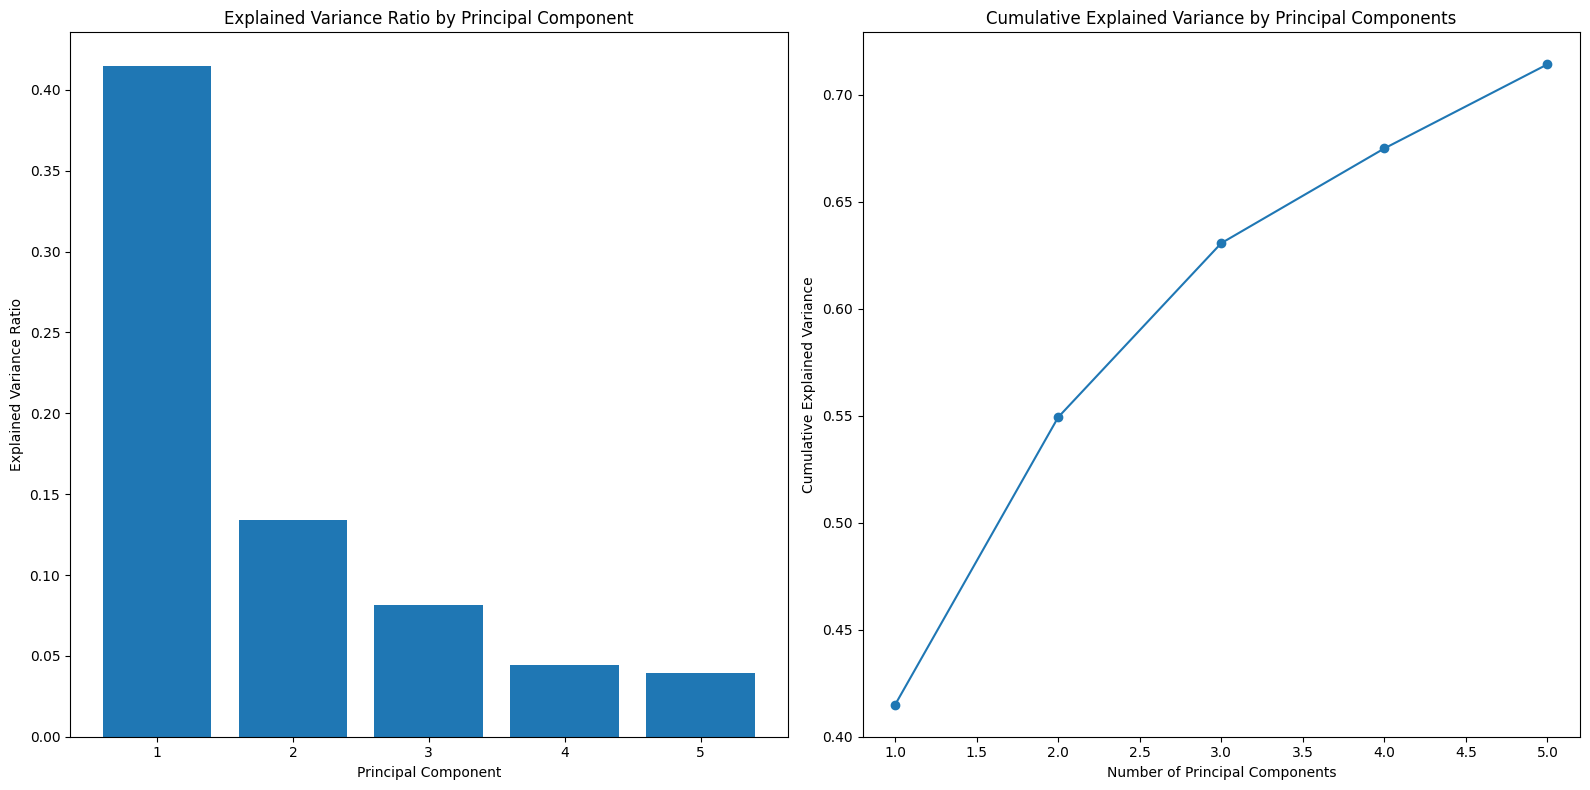

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

In [70]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_lab_enc.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

In [71]:
# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,hcpcs_181_enc
1,PC2,hcpcs_102_enc
2,PC3,hcpcs_180_enc
3,PC4,category_23_enc
4,PC5,category_315_enc


In [78]:
principal_df = pd.DataFrame(data= X_pca)

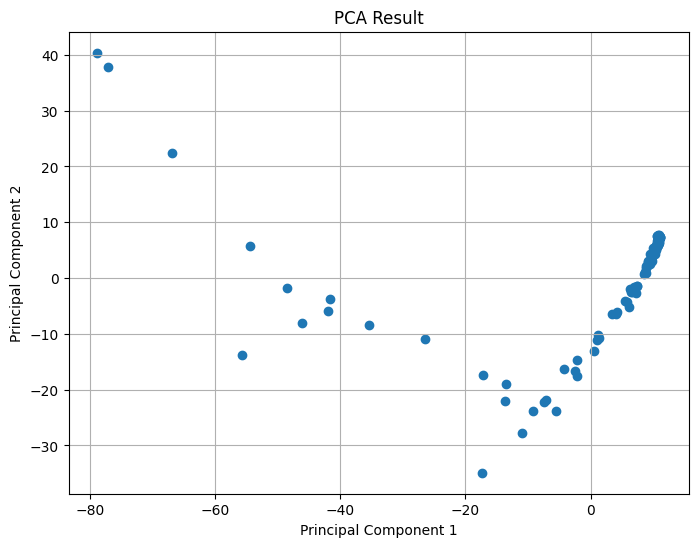

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(principal_df[0], principal_df[1])
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


Unsupervised Learning Methods code

In [40]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=12, n_init=10, random_state = 0) 
model = kmeans.fit(df_lab_enc) 
#model.predict(df_lab_enc)
model.n_iter_
labels = model.labels_
print(labels)


[ 3  9  5  5  5  5  8 11  7  3  2  5  9  5  3  5  5 11  5 11  6  8  4  7
  2 10  5  6  4  3 11  0 11  5  5  5  6  5 10  3 11  5  4  4  3  2  5  5
  2 11  5  4  3 11  3  9  3  3  6  5  9  4  3  5  5  3  3  5  2  0 10  3
  5  0  3  5  5  6  6  8  3  8  3 11 10  3  5  8  2  0  3 11 11  1  4 11
  5  3 11 10  5  4  5 11  5  1  0  5  4 11  0  6  5  5  6  3  9 10  5 11
  5  0  5  9 11  5 10  5  5  5  6  4 11 11  3  3  0  8  0  5  5  7 11  7
  5  3  5]


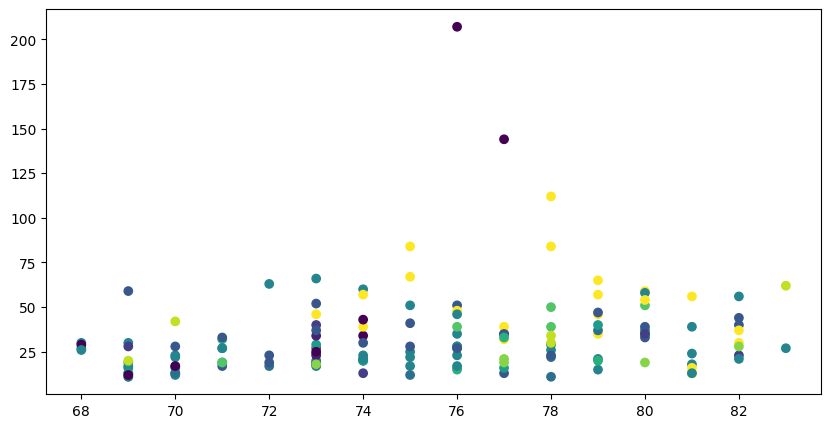

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.iloc[:, 2], y=df_lab_enc.iloc[:, 3], c= model.labels_)

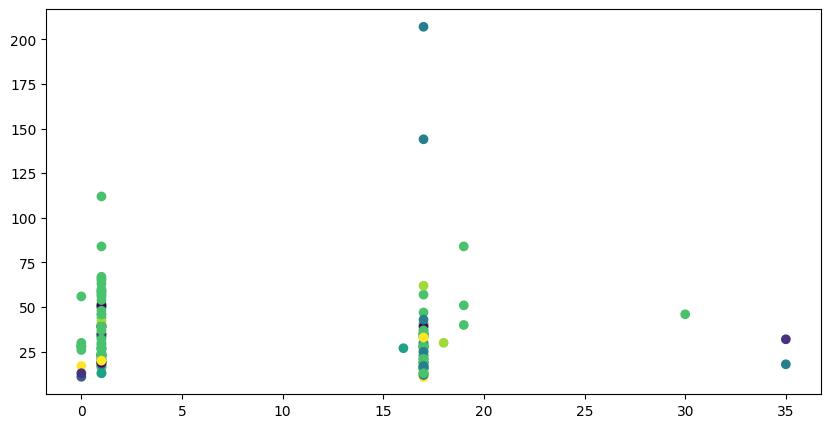

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.loc[:, 'hcpcs_0_enc'], y=df_lab_enc.loc[:, 'number_of_claims'], c= model.labels_)
# plt.xlabel('Annual Income (k$)')
# plt.ylabel('Spending Score (1-100)')

In [ ]:
# Assign the cluster centers: centroids
centroids = model.cluster_centers_# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

In [ ]:
for i, cluster in enumerate(clusters):
    plt.scatter(data[:, 0], data[:, 1], c=cluster, label=f'Cluster {i+1}')
plt.scatter(*centroids, c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


In [ ]:
# works for AgglomerativeClustering, FeatureAgglomerization and DBScan
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X_train)


In [ ]:
# GMM code
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X_train)

Model Evaluation

In [ ]:
# elbow method

# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_train, labels)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Visualizations:

word cloud 
